# CS542 - Class Challenge - fine-grained classification of plants:

Our class challenge will consists of two tasks addressing an image recognition task where our dataset contains about 1K categories of plants with only about 250,000 images.  There will be two parts to this task:

1. Image classification. Imagine we have cateloged all the plants we care to identify, now we just need to create a classifier for them! Use your skills from the supervised learning sections of this course to try to address this problem.

2. Semi-Supervised/Few-Shot Learning.  Unfortunately, we missed some important plants we want to classify!  We do have some images we think contain the plant, but we have only have a few labels.  Our new goal is to develop an AI model that can learn from just these labeled examples.

Each student must submit a model on both tasks.  Students in the top 3 on each task will get 5% extra credit on this assignment.

This notebook is associated with the first task (image classification).


# Dataset
The dataset is downloaded on scc in the address: "/projectnb2/cs542-bap/classChallenge/data". You can find the python version of this notebook there as well or you could just type "jupyter nbconvert --to script baselineModel_task1.ipynb" and it will output "baselineModel_task1.py". You should be able to run "baselineModel_task1.py" on scc by simply typing "python baselineModel_task1.py"

Please don't try to change or delete the dataset.

# Evaluation:
You will compete with each other over your performance on the dedicated test set. The performance measure is top the 5 error, i.e: if the true class is in one of your top 5 likely predictions, then its error is 0, otherwise its error is 1.  So, your goal is to get an error of 0. This notebook outputs top5 accuracy, so it is 1 - top5 error.

# Baseline:
The following code is a baseline which you can use and improve to come up with your model for this task

# Suggestion
One simple suggestion would be to use a pretrained model on imagenet and finetune it on this data similar to this [link](https://keras.io/api/applications/)
Also you should likely train more than 2 epochs.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explore the dataset

In [2]:
import pathlib
data_dir = '/projectnb2/cs542-bap/class_challenge/'
image_dir = os.path.join(data_dir, 'images')
image_dir = pathlib.Path(image_dir)
#image_count = len(list(image_dir.glob('*.jpg')))
#print("Total number of images = ",image_count)

In [3]:
print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(os.getenv("CUDA_VISIBLE_DEVICES"))
tf.config.set_soft_device_placement(True)
def get_n_cores():
  nslots = os.getenv('NSLOTS')
  if nslots is not None:
    return int(nslots)
  raise ValueError('Environment variable NSLOTS is not defined.')
print("NUM CORES: ", get_n_cores())
tf.config.threading.set_intra_op_parallelism_threads(get_n_cores()-1)
tf.config.threading.set_inter_op_parallelism_threads(1)

2.3.1
Num GPUs Available:  1
1
NUM CORES:  4


## Here are some images

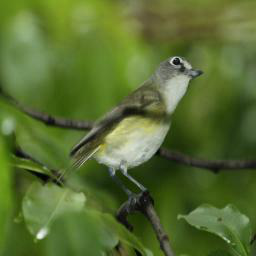

In [4]:
PIL.Image.open(os.path.join(image_dir, '100.jpg'))

# Create a dataset

In [5]:
train_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'train.txt'))
val_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'val.txt'))
test_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'test.txt'))

with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
  class_names = [c.strip() for c in f.readlines()]
  
num_classes = len(class_names)

## Write a short function that converts a file path to an (img, label) pair:

In [6]:
def decode_img(img, crop_size=224):
  img = tf.io.read_file(img)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [crop_size, crop_size])

def get_label(label):
  # find teh matching label
  one_hot = tf.where(tf.equal(label, class_names))
  # Integer encode the label
  return tf.reduce_min(one_hot)

def process_path(file_path):
  # should have two parts
  file_path = tf.strings.split(file_path)
  # second part has the class index
  label = get_label(file_path[1])
  # load the raw data from the file
  img = decode_img(tf.strings.join([data_dir, 'images/', file_path[0], '.jpg']))
  return img, label

def process_path_test(file_path):
  # load the raw data from the file
  img = decode_img(tf.strings.join([data_dir, 'images/', file_path, '.jpg']))
  return img, file_path

## Finish setting up data

In [7]:
batch_size = 32

In [8]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path_test, num_parallel_calls=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [9]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  868


In [10]:
def augmentFlipUD(img, label):
    return tf.image.flip_up_down(img), label

def augmentFlipLR(img, label):
    return tf.image.flip_left_right(img), label

def augmentRotate(img, label):
    if np.random.random() < .5:
        return tf.image.rot90(img, k=1), label
    else:
        return tf.image.rot90(img, k=3), label
    
#Let's augment and grow our training set 4x

#tdsAugment = train_ds.map(augmentFlipUD, num_parallel_calls=AUTOTUNE)
#tdsAugment = tdsAugment.concatenate(train_ds.map(augmentFlipLR, num_parallel_calls=AUTOTUNE))
#tdsAugment = tdsAugment.concatenate(train_ds.map(augmentRotate, num_parallel_calls=AUTOTUNE))

#We will apply only one augment for training performance
train_ds = train_ds.concatenate(train_ds.map(augmentFlipLR, num_parallel_calls=AUTOTUNE))

## Data loader hyper-parameters for performance!

In [11]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

## Here are some resized images ready to use!

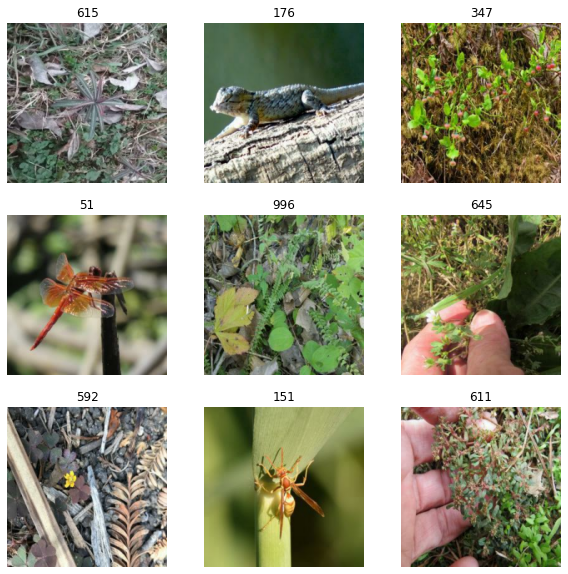

In [12]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Improved Baseline

In [13]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, activation='relu'),
  layers.Flatten(),
  layers.Dense(1024),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

## The usual loss function

In [14]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])

## Training

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("baselineAugmented.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1000)

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=.1, patience=5)

hist = model.fit(train_ds,validation_data=val_ds,epochs=12,shuffle=True, callbacks=[checkpoint, es])

Epoch 1/12
    999/Unknown - 185s 185ms/step - loss: 6.7028 - accuracy: 0.0025 - sparse_top_k_categorical_accuracy: 0.0122
Epoch 00001: loss improved from inf to 6.70247, saving model to baselineAugmented.hdf5
   1999/Unknown - 337s 169ms/step - loss: 6.5463 - accuracy: 0.0043 - sparse_top_k_categorical_accuracy: 0.0214
Epoch 00001: loss improved from 6.70247 to 6.54600, saving model to baselineAugmented.hdf5
   2999/Unknown - 504s 168ms/step - loss: 6.3811 - accuracy: 0.0084 - sparse_top_k_categorical_accuracy: 0.0357
Epoch 00001: loss improved from 6.54600 to 6.38088, saving model to baselineAugmented.hdf5
   3999/Unknown - 650s 163ms/step - loss: 6.2275 - accuracy: 0.0133 - sparse_top_k_categorical_accuracy: 0.0518
Epoch 00001: loss improved from 6.38088 to 6.22736, saving model to baselineAugmented.hdf5
   4999/Unknown - 787s 157ms/step - loss: 6.0871 - accuracy: 0.0185 - sparse_top_k_categorical_accuracy: 0.0673
Epoch 00001: loss improved from 6.22736 to 6.08697, saving model to b

In [ ]:
#Reload model and keep training because of kernel death

from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("baselineAugmented.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1000)

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=.1, patience=5)

new_model = keras.models.load_model('baselineAugmented.hdf5')
hist = new_model.fit(train_ds, validation_data=val_ds, epochs=12, shuffle=True, callbacks=[checkpoint, es])

Epoch 1/12
    999/Unknown - 91s 91ms/step - loss: 3.3811 - accuracy: 3.1281e-04 - sparse_top_k_categorical_accuracy: 0.5253
Epoch 00001: loss improved from inf to 3.38055, saving model to baselineAugmented.hdf5
   1999/Unknown - 181s 90ms/step - loss: 3.3915 - accuracy: 3.1266e-04 - sparse_top_k_categorical_accuracy: 0.5227
Epoch 00001: loss did not improve from 3.38055
   2999/Unknown - 271s 90ms/step - loss: 3.3877 - accuracy: 2.7092e-04 - sparse_top_k_categorical_accuracy: 0.5241
Epoch 00001: loss did not improve from 3.38055
   3999/Unknown - 416s 104ms/step - loss: 3.3749 - accuracy: 3.5946e-04 - sparse_top_k_categorical_accuracy: 0.5269
Epoch 00001: loss improved from 3.38055 to 3.37489, saving model to baselineAugmented.hdf5
   4341/Unknown - 462s 106ms/step - loss: 3.3690 - accuracy: 3.4554e-04 - sparse_top_k_categorical_accuracy: 0.5280

# Output submission csv for Kaggle


In [ ]:
with open('/projectnb2/cs542-bap/alihus/simpleAugment_task1_supervised.csv', 'w') as f:
  f.write('id,predicted\n')
  for image_batch, image_names in test_ds:
    predictions = model.predict(image_batch)
    for image_name, predictions in zip(image_names.numpy(), model.predict(image_batch)):
      inds = np.argpartition(predictions, -5)[-5:]
      line = str(int(image_name)) + ',' + ' '.join([class_names[i] for i in inds])
      f.write(line + '\n')

**Note**

Absolute path is recommended here. For example, use "/projectnb2/cs542-bap/[your directory name]/submission_task1_supervised.csv" to replace "submission_task1_supervised.csv".

Besides, you can request good resources by specify the type of gpus, such as "qsub -l gpus=1 -l gpu_type=P100 [your file name].qsub". This is helpful to avoid potential issues of GPUs, such as out of memory, etc.
